<a href="https://colab.research.google.com/github/jgranizo/HackNJIT2024/blob/main/XGBoost_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
# Additional libraries as needed
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report

#regulrization
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Technical Analysis library
!pip install ta
import ta
!pip install yfinance
import yfinance as yf

In [19]:
merged_df = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/final_df.csv')

In [20]:
merged_df

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,polarity,date,Tesla_MA_100,...,Tesla_Bollinger_Upper_5,Tesla_Bollinger_Lower_5,Tesla_Bollinger_Upper_50,Tesla_Bollinger_Lower_50,Tesla_RSI_5,Tesla_RSI_50,Tesla_MACD,Tesla_Log_Return_Lag1,Tesla_Log_Return_Lag5,Tesla_Direction
0,21.847334,6.993325,-0.001281,-0.012695,19.543734,16.165733,0.057309,0.000,2019-10-28,15.806087,...,24.420928,14.666539,19.311189,13.020278,98.282345,70.265892,1.152629,0.090695,-0.013518,0
1,21.081333,7.017694,-0.035691,0.003478,20.352267,16.284920,0.060164,0.000,2019-10-29,15.880567,...,24.427467,16.277067,19.708293,12.861547,85.149520,66.523709,1.264520,-0.001281,0.008172,0
2,21.000668,6.936469,-0.003834,-0.011642,21.156667,16.403787,0.060533,0.000,2019-10-30,15.948653,...,22.709471,19.603863,20.058121,12.749452,84.844643,66.464741,1.331339,-0.035691,-0.003528,0
3,20.994667,6.977082,-0.000286,0.005838,21.359867,16.529240,0.060770,0.000,2019-10-31,16.013867,...,22.278184,20.441550,20.373656,12.684824,68.290934,67.700057,1.368039,-0.003834,0.162707,0
4,20.887333,7.220751,-0.005126,0.034328,21.162267,16.650787,0.059949,0.000,2019-11-01,16.083233,...,21.940508,20.384025,20.654334,12.647239,0.000000,67.130176,1.372640,-0.000286,0.090695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,216.520004,10.623935,0.020719,-0.007871,220.676001,248.037200,0.035287,0.649,2023-10-24,253.318000,...,246.192780,195.159222,281.669914,214.404485,9.558976,46.079094,-9.012315,0.000424,0.003656,1
1005,212.419998,10.763846,-0.019118,0.013084,214.624002,247.626400,0.034769,0.860,2023-10-25,253.302500,...,221.832227,207.415777,282.490016,212.762783,11.520854,46.502757,-10.148612,0.020719,-0.048931,0
1006,205.759995,10.586625,-0.031855,-0.016602,211.754001,247.229599,0.034855,0.691,2023-10-26,253.184000,...,219.451301,204.056701,283.538131,210.921068,19.350697,46.613870,-11.454502,-0.019118,-0.097616,0
1007,207.300003,9.290113,0.007457,-0.130641,210.816000,246.991199,0.035994,0.767,2023-10-27,253.043900,...,219.454959,202.177042,284.195856,209.786543,36.066555,47.931418,-12.224250,-0.031855,-0.037588,1


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tesla                     1009 non-null   float64
 1   Ford                      1009 non-null   float64
 2   Tesla_Log_Return          1009 non-null   float64
 3   Ford_Log_Return           1009 non-null   float64
 4   Tesla_MA_5                1009 non-null   float64
 5   Tesla_MA_50               1009 non-null   float64
 6   Tesla_Volatility          1009 non-null   float64
 7   polarity                  1009 non-null   float64
 8   date                      1009 non-null   object 
 9   Tesla_MA_100              1009 non-null   float64
 10  Tesla_MA_200              1009 non-null   float64
 11  Tesla_Bollinger_Upper_5   1009 non-null   float64
 12  Tesla_Bollinger_Lower_5   1009 non-null   float64
 13  Tesla_Bollinger_Upper_50  1009 non-null   float64
 14  Tesla_Bo

In [22]:
test_size = int(len(merged_df) * 0.2)  # e.g., 20% of data for testing
train_data = merged_df[:-test_size]
test_data = merged_df[-test_size:]

In [23]:
train_data

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,polarity,date,Tesla_MA_100,...,Tesla_Bollinger_Upper_5,Tesla_Bollinger_Lower_5,Tesla_Bollinger_Upper_50,Tesla_Bollinger_Lower_50,Tesla_RSI_5,Tesla_RSI_50,Tesla_MACD,Tesla_Log_Return_Lag1,Tesla_Log_Return_Lag5,Tesla_Direction
0,21.847334,6.993325,-0.001281,-0.012695,19.543734,16.165733,0.057309,0.0000,2019-10-28,15.806087,...,24.420928,14.666539,19.311189,13.020278,98.282345,70.265892,1.152629,0.090695,-0.013518,0
1,21.081333,7.017694,-0.035691,0.003478,20.352267,16.284920,0.060164,0.0000,2019-10-29,15.880567,...,24.427467,16.277067,19.708293,12.861547,85.149520,66.523709,1.264520,-0.001281,0.008172,0
2,21.000668,6.936469,-0.003834,-0.011642,21.156667,16.403787,0.060533,0.0000,2019-10-30,15.948653,...,22.709471,19.603863,20.058121,12.749452,84.844643,66.464741,1.331339,-0.035691,-0.003528,0
3,20.994667,6.977082,-0.000286,0.005838,21.359867,16.529240,0.060770,0.0000,2019-10-31,16.013867,...,22.278184,20.441550,20.373656,12.684824,68.290934,67.700057,1.368039,-0.003834,0.162707,0
4,20.887333,7.220751,-0.005126,0.034328,21.162267,16.650787,0.059949,0.0000,2019-11-01,16.083233,...,21.940508,20.384025,20.654334,12.647239,0.000000,67.130176,1.372640,-0.000286,0.090695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,110.339996,10.501588,-0.029469,0.019786,115.415999,173.777000,0.071763,0.4940,2023-01-05,221.492600,...,128.970879,101.861118,243.731447,103.822552,46.554228,32.685909,-19.501870,0.049979,0.032553,0
804,113.059998,10.784489,0.024352,0.026582,113.663998,171.589800,0.073052,0.0260,2023-01-06,219.530000,...,125.193386,102.134611,242.172288,101.007311,34.357143,30.675717,-18.963374,-0.029469,0.077726,1
805,119.769997,10.878787,0.057655,0.008706,112.981998,169.492400,0.071757,0.5170,2023-01-09,217.662067,...,121.775749,104.188246,239.872788,99.112012,44.887552,31.758569,-17.790098,0.024352,0.011102,1
806,118.849998,11.007380,-0.007711,0.011751,115.131998,167.367600,0.071623,0.0525,2023-01-10,215.810600,...,123.182904,107.081092,237.310410,97.424790,78.009376,31.550434,-16.741519,0.057655,-0.130590,0


In [24]:
test_data

,Tesla,Ford,Tesla_Log_Return,Ford_Log_Return,Tesla_MA_5,Tesla_MA_50,Tesla_Volatility,polarity,date,Tesla_MA_100,...,Tesla_Bollinger_Upper_5,Tesla_Bollinger_Lower_5,Tesla_Bollinger_Upper_50,Tesla_Bollinger_Lower_50,Tesla_RSI_5,Tesla_RSI_50,Tesla_MACD,Tesla_Log_Return_Lag1,Tesla_Log_Return_Lag5,Tesla_Direction
808,123.559998,11.513170,0.002755,0.015760,119.691998,163.182000,0.058716,0.295,2023-01-12,212.283034,...,128.183565,111.200432,230.527457,95.836543,93.891113,31.961699,-14.111938,0.036109,-0.029469,1
809,122.400002,10.904507,-0.009432,-0.054315,121.559999,161.073600,0.053664,0.000,2023-01-13,210.607901,...,125.803749,117.316249,226.739179,95.408020,84.592627,31.767554,-13.049695,0.002755,0.024352,0
810,131.490005,10.861642,0.071636,-0.003939,123.904001,159.403800,0.058217,0.103,2023-01-17,208.958267,...,133.174309,114.633693,223.706331,95.101269,86.901797,35.370600,-11.343610,-0.009432,0.057655,1
811,128.779999,10.638751,-0.020825,-0.020734,125.890001,157.673200,0.035347,0.000,2023-01-18,207.275100,...,133.918080,117.861922,220.474509,94.871890,78.098464,34.963334,-10.093844,0.071636,-0.007711,0
812,127.169998,10.441579,-0.012581,-0.018707,126.680000,156.067200,0.034486,0.000,2023-01-19,205.586100,...,134.152553,119.207447,217.768135,94.366264,63.246130,35.737123,-9.128087,-0.020825,0.036109,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,216.520004,10.623935,0.020719,-0.007871,220.676001,248.037200,0.035287,0.649,2023-10-24,253.318000,...,246.192780,195.159222,281.669914,214.404485,9.558976,46.079094,-9.012315,0.000424,0.003656,1
1005,212.419998,10.763846,-0.019118,0.013084,214.624002,247.626400,0.034769,0.860,2023-10-25,253.302500,...,221.832227,207.415777,282.490016,212.762783,11.520854,46.502757,-10.148612,0.020719,-0.048931,0
1006,205.759995,10.586625,-0.031855,-0.016602,211.754001,247.229599,0.034855,0.691,2023-10-26,253.184000,...,219.451301,204.056701,283.538131,210.921068,19.350697,46.613870,-11.454502,-0.019118,-0.097616,0
1007,207.300003,9.290113,0.007457,-0.130641,210.816000,246.991199,0.035994,0.767,2023-10-27,253.043900,...,219.454959,202.177042,284.195856,209.786543,36.066555,47.931418,-12.224250,-0.031855,-0.037588,1


In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report

# Define features and target for classification
X_train_classification = train_data.drop(columns=['Tesla_Log_Return', 'Tesla_Direction', 'date'])
y_train_classification = train_data['Tesla_Direction']

# Define features and target for the test set
X_test_classification = test_data.drop(columns=['Tesla_Log_Return', 'Tesla_Direction', 'date'])
y_test_classification = test_data['Tesla_Direction']

# Parameter grid for hyperparameter tuning
param_grid_class = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# TimeSeriesSplit for cross-validation within the training data
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBClassifier with GPU support
xgb_classifier = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# GridSearchCV for hyperparameter tuning
grid_search_class = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_class,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the classifier with GridSearchCV on the training data
grid_search_class.fit(X_train_classification, y_train_classification)

# Print the best parameters and the best accuracy score
print("Best parameters for classification:", grid_search_class.best_params_)
print("Best accuracy for classification (validation):", grid_search_class.best_score_)

# Refit the model on the entire training set with the best parameters
best_xgb_classifier = grid_search_class.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for classification: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Best accuracy for classification (validation): 0.6761194029850747


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Testing on unseen data

In [26]:
y_test_pred = best_xgb_classifier.predict(X_test_classification)
test_accuracy = accuracy_score(y_test_classification, y_test_pred)

print("\nTest Accuracy:", test_accuracy)
print("\nClassification Report on Test Set:\n", classification_report(y_test_classification, y_test_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



Test Accuracy: 0.7164179104477612

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71        94
           1       0.75      0.70      0.72       107

    accuracy                           0.72       201
   macro avg       0.72      0.72      0.72       201
weighted avg       0.72      0.72      0.72       201



Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71        94
           1       0.75      0.70      0.72       107

    accuracy                           0.72       201
   macro avg       0.72      0.72      0.72       201
weighted avg       0.72      0.72      0.72       201



<Figure size 800x600 with 0 Axes>

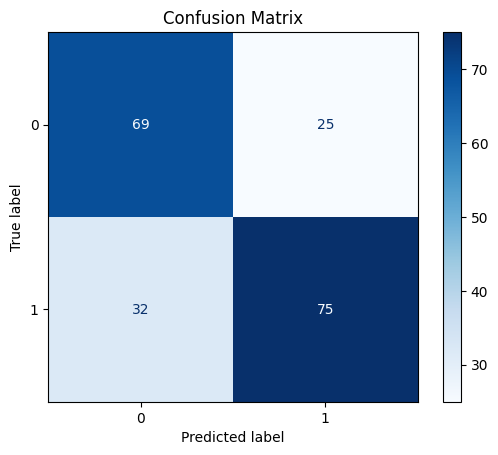

In [27]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming `y_test_classification` and `y_test_pred` are the actual and predicted labels from the test set

# Print the classification report
print("Classification Report:\n", classification_report(y_test_classification, y_test_pred))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classification, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Regression

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for regression: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE for regression: 0.03680819690422595


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:00:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in versio


Test RMSE: 0.028299518455497122
Test R^2 Score: 0.3154786275230227


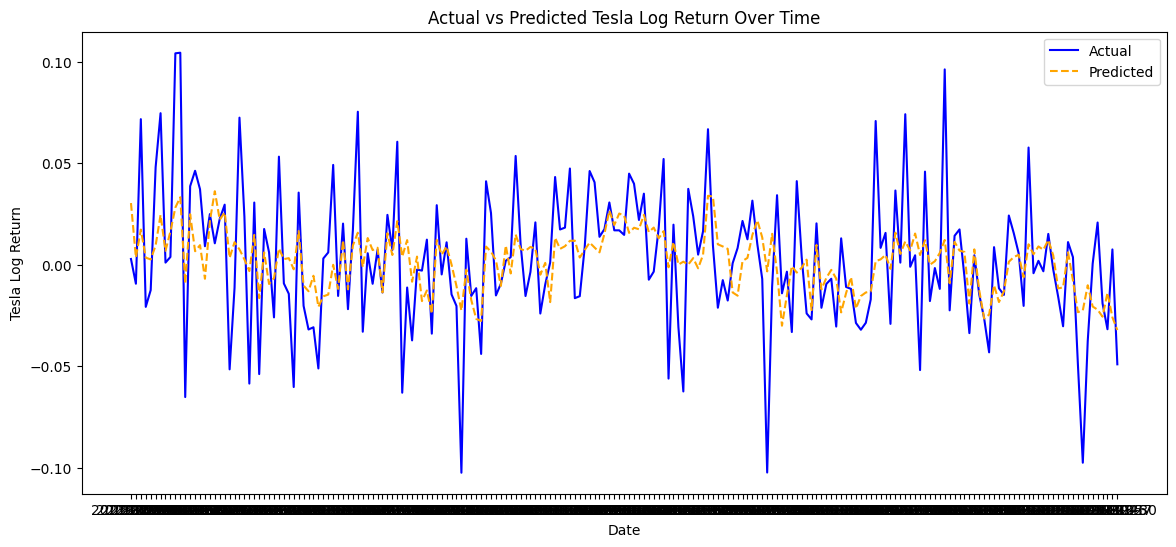

In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target for regression
X_regression = merged_df.drop(columns=['Tesla_Log_Return', 'Tesla_Direction', 'date'])
y_regression = merged_df['Tesla_Log_Return']

# Split the data into training and testing sets (20% for test set)
test_size = int(len(merged_df) * 0.2)
X_train_regression, X_test_regression = X_regression[:-test_size], X_regression[-test_size:]
y_train_regression, y_test_regression = y_regression[:-test_size], y_regression[-test_size:]

# Parameter grid for hyperparameter tuning
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBRegressor with GPU support
xgb_regressor = XGBRegressor(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42
)

# GridSearchCV for hyperparameter tuning
grid_search_reg = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid_reg,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the regressor with GridSearchCV on the training data
grid_search_reg.fit(X_train_regression, y_train_regression)

# Print best parameters and best RMSE score
print("Best parameters for regression:", grid_search_reg.best_params_)
print("Best RMSE for regression:", (-grid_search_reg.best_score_)**0.5)

# Use the best estimator from GridSearchCV
best_xgb_regressor = grid_search_reg.best_estimator_

# Fit the best model on the full training set
best_xgb_regressor.fit(X_train_regression, y_train_regression)

# Make predictions on the test set
y_test_pred = best_xgb_regressor.predict(X_test_regression)

# Calculate RMSE and R^2 score on the test set
test_rmse = mean_squared_error(y_test_regression, y_test_pred, squared=False)
test_r2 = r2_score(y_test_regression, y_test_pred)
print(f"\nTest RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")

# Plot Actual vs. Predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_data['date'], y_test_regression, label='Actual', color='blue')
plt.plot(test_data['date'], y_test_pred, label='Predicted', color='orange', linestyle='dashed')
plt.title('Actual vs Predicted Tesla Log Return Over Time')
plt.xlabel('Date')
plt.ylabel('Tesla Log Return')
plt.legend()
plt.show()

## Residuals




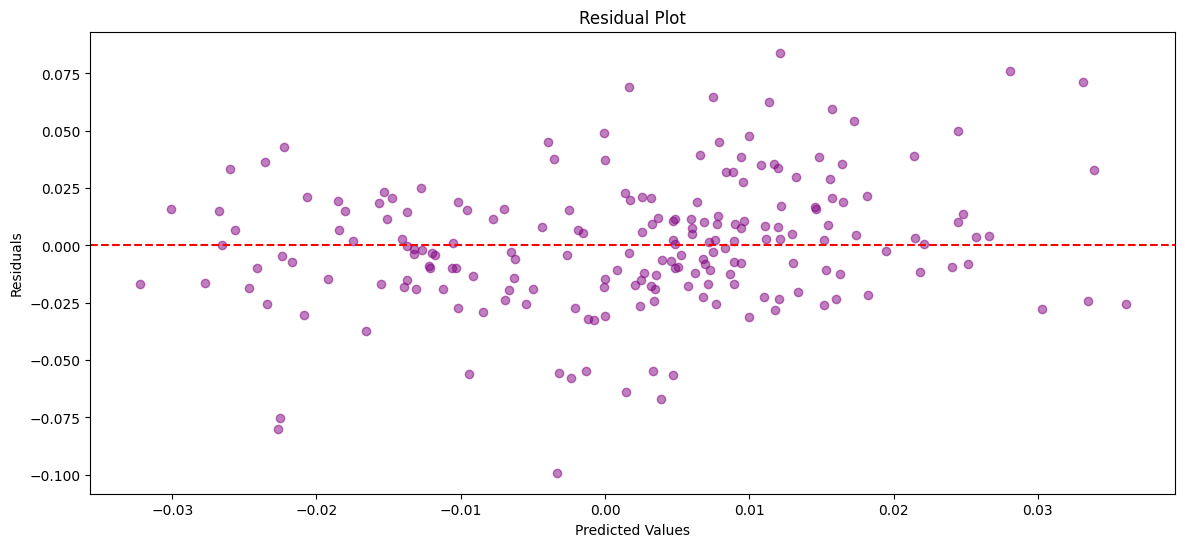

In [29]:
# Calculate residuals
residuals = y_test_regression - y_test_pred

# Plot residuals
plt.figure(figsize=(14, 6))
plt.scatter(y_test_pred, residuals, color='purple', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


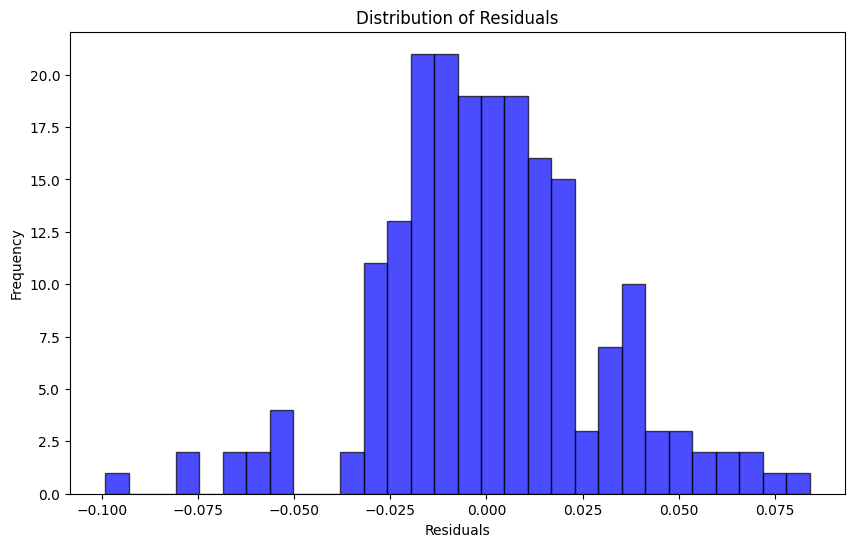

In [30]:
# Plot histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

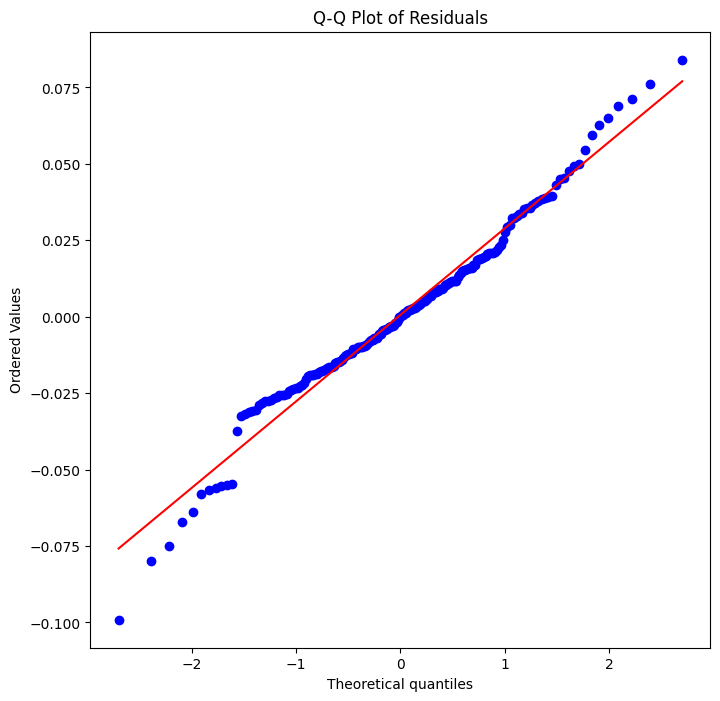

In [31]:
import scipy.stats as stats

# Q-Q plot
plt.figure(figsize=(8, 8))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Random Search

In [40]:
import xgboost
print(xgboost.__version__)


2.1.2


In [41]:
pip install --upgrade xgboost


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 10, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.005, 'gamma': 0, 'colsample_bytree': 0.6}
Best RMSE from random search: 0.03676994614733332
[0]	validation_0-rmse:0.03414
[1]	validation_0-rmse:0.03412
[2]	validation_0-rmse:0.03407
[3]	validation_0-rmse:0.03404
[4]	validation_0-rmse:0.03400
[5]	validation_0-rmse:0.03396
[6]	validation_0-rmse:0.03393
[7]	validation_0-rmse:0.03390
[8]	validation_0-rmse:0.03387
[9]	validation_0-rmse:0.03382
[10]	validation_0-rmse:0.03378
[11]	validation_0-rmse:0.03378
[12]	validation_0-rmse:0.03376
[13]	validation_0-rmse:0.03371
[14]	validation_0-rmse:0.03366
[15]	validation_0-rmse:0.03361
[16]	validation_0-rmse:0.03357
[17]	validation_0-rmse:0.03356
[18]	validation_0-rmse:0.03353
[19]	validation_0-rmse:0.03350
[20]	validation_0-rmse:0.03350
[21]	validation_0-rmse:0.03347
[22]	validation_0-

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


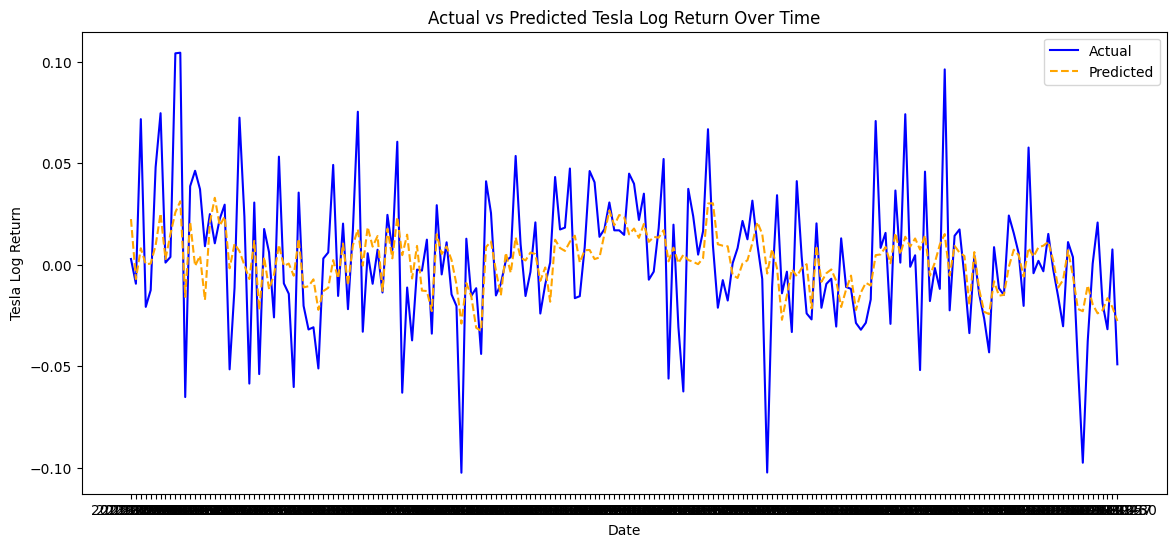

In [45]:
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Parameter grid for hyperparameter tuning
param_grid_reg = {
    'n_estimators': [200, 300, 500],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.005, 0.01, 0.05],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 5, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5, 1]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBRegressor with GPU support
xgb_regressor = XGBRegressor(
    tree_method='hist',
    device='cuda',
    random_state=42,
)
# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=param_grid_reg,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_iter=50,  # Set the number of random combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the regressor with RandomizedSearchCV on the training data
random_search.fit(X_train_regression, y_train_regression)

print("Best parameters found:", random_search.best_params_)
print("Best RMSE from random search:", (-random_search.best_score_) ** 0.5)

# Use the best estimator from RandomizedSearchCV
best_xgb_regressor = XGBRegressor(
    **random_search.best_params_,
    tree_method='hist',
    device='cuda',
    random_state=42,
    early_stopping_rounds=10
)
# Fit with early stopping on the full training set
best_xgb_regressor.fit(
    X_train_regression,
    y_train_regression,
    eval_set=[(X_test_regression, y_test_regression)],  # Early stopping after 10 rounds of no improvement
    verbose=True
)

# Make predictions on the test set
y_test_pred = best_xgb_regressor.predict(X_test_regression)

# Calculate RMSE and R^2 score on the test set
test_rmse = mean_squared_error(y_test_regression, y_test_pred, squared=False)
test_r2 = r2_score(y_test_regression, y_test_pred)

print(f"\nTest RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")

# Define test_dates
test_dates = merged_df['date'][-test_size:]

# Plot Actual vs. Predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_regression, label='Actual', color='blue')
plt.plot(test_dates, y_test_pred, label='Predicted', color='orange', linestyle='dashed')
plt.title('Actual vs Predicted Tesla Log Return Over Time')
plt.xlabel('Date')
plt.ylabel('Tesla Log Return')
plt.legend()
plt.show()



In [46]:
best_xgb_regressor.save_model('best_xgb_regressor.model')

# To load the model later
from xgboost import XGBRegressor
best_xgb_regressor = XGBRegressor()
best_xgb_regressor.load_model('best_xgb_regressor.model')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:02:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Define features and target for classification
X_classification = merged_df.drop(columns=['Tesla_Log_Return', 'Tesla_Direction', 'date'])
y_classification = merged_df['Tesla_Direction']

# Split the data into training and testing sets (20% for test set)
test_size = int(len(merged_df) * 0.2)
X_train_full, X_test = X_classification[:-test_size], X_classification[-test_size:]
y_train_full, y_test = y_classification[:-test_size], y_classification[-test_size:]

# Further split the training data into training and validation sets (10% of training data for validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, shuffle=False
)

# Parameter grid for hyperparameter tuning
param_grid_class = {
    'n_estimators': [100, 200, 500],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1, 5, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5, 1]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBClassifier with GPU support
xgb_classifier = XGBClassifier(
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid_class,
    cv=tscv,
    scoring='accuracy',
    n_iter=50,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the classifier with RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best accuracy from random search:", random_search.best_score_)

# Use the best estimator from RandomizedSearchCV
best_xgb_classifier = XGBClassifier(
    **random_search.best_params_,
    tree_method='hist',
    device='cuda',
    random_state=42,
    use_label_encoder=False,
    early_stopping=10,
    eval_metric='logloss'
)

# Fit with early stopping on the training set
best_xgb_classifier.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# Make predictions on the test set
y_test_pred = best_xgb_classifier.predict(X_test)

# Calculate accuracy and classification report on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Save the best classifier model to a file
joblib.dump(best_xgb_classifier, 'best_xgb_classifier.pkl')


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 1.0}
Best accuracy from random search: 0.6578512396694215
[0]	validation_0-logloss:0.71224
[1]	validation_0-logloss:0.70947
[2]	validation_0-logloss:0.70676
[3]	validation_0-logloss:0.70412
[4]	validation_0-logloss:0.70158
[5]	validation_0-logloss:0.69906
[6]	validation_0-logloss:0.69677
[7]	validation_0-logloss:0.69436
[8]	validation_0-logloss:0.69210
[9]	validation_0-logloss:0.68991
[10]	validation_0-logloss:0.68785
[11]	validation_0-logloss:0.68576
[12]	validation_0-logloss:0.68378
[13]	validation_0-logloss:0.68182
[14]	validation_0-logloss:0.67989
[15]	validation_0-logloss:0.67796
[16]	validation_0-logloss:0.67617
[17]	validation_0-logloss:0.67431
[18]	validation_0-logloss:0.67250
[19]	validation_0-logloss:0.67078
[20]	validation_0-logloss:0.66915
[21]	validation_0-logloss:0.66735
[22]	validatio

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:06:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_stopping", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-logloss:0.64232
[38]	validation_0-logloss:0.64081
[39]	validation_0-logloss:0.63979
[40]	validation_0-logloss:0.63838
[41]	validation_0-logloss:0.63716
[42]	validation_0-logloss:0.63609
[43]	validation_0-logloss:0.63476
[44]	validation_0-logloss:0.63407
[45]	validation_0-logloss:0.63296
[46]	validation_0-logloss:0.63170
[47]	validation_0-logloss:0.63045
[48]	validation_0-logloss:0.62976
[49]	validation_0-logloss:0.62919
[50]	validation_0-logloss:0.62799
[51]	validation_0-logloss:0.62736
[52]	validation_0-logloss:0.62621
[53]	validation_0-logloss:0.62567
[54]	validation_0-logloss:0.62519
[55]	validation_0-logloss:0.62411
[56]	validation_0-logloss:0.62362
[57]	validation_0-logloss:0.62260
[58]	validation_0-logloss:0.62218
[59]	validation_0-logloss:0.62177
[60]	validation_0-logloss:0.62076
[61]	validation_0-logloss:0.62048
[62]	validation_0-logloss:0.62011
[63]	validation_0-logloss:0.61914
[64]	validation_0-logloss:0.61878
[65]	validation_0-logloss:0.61844
[66]	validatio

['best_xgb_classifier.pkl']

# Confustion Matrix

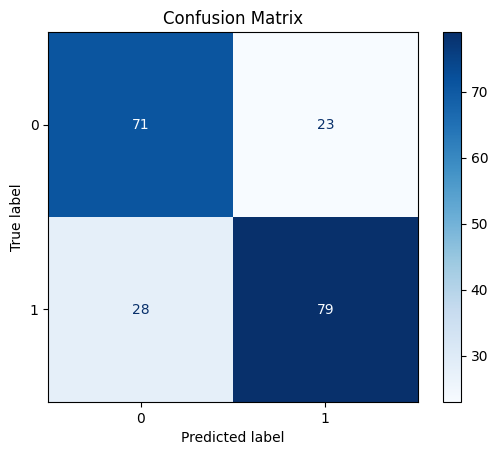

In [48]:
cm = confusion_matrix(y_test, y_test_pred, labels=best_xgb_classifier.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_xgb_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC Score

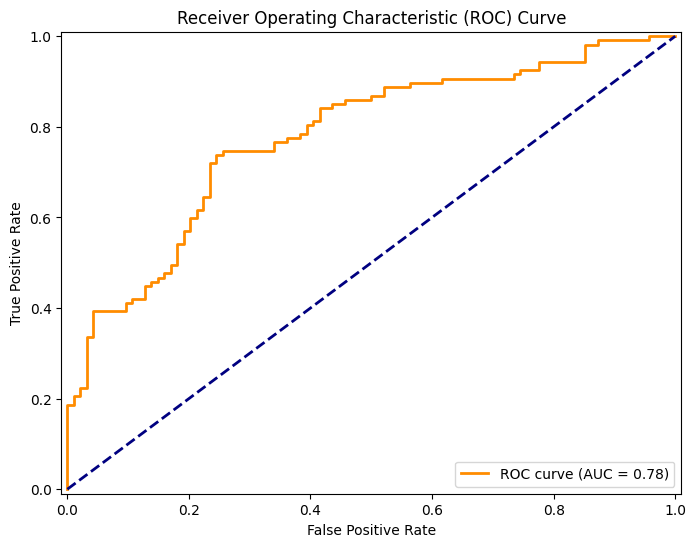

In [49]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_test_proba = best_xgb_classifier.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve

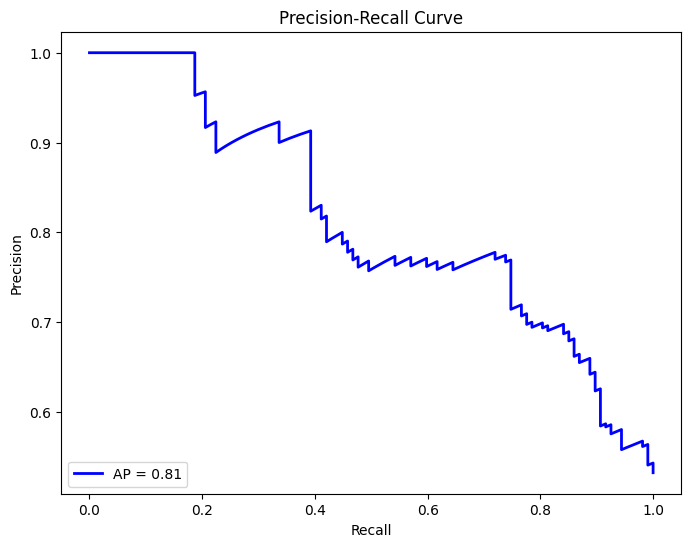

In [50]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
average_precision = average_precision_score(y_test, y_test_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Feature Importance

<Figure size 1000x800 with 0 Axes>

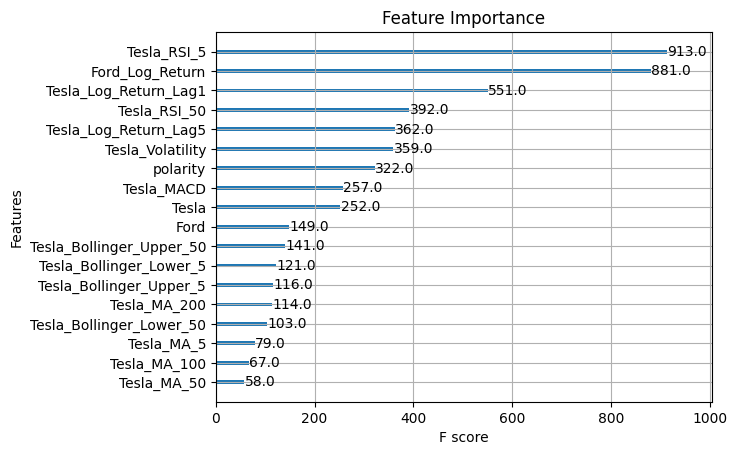

In [51]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb_classifier, max_num_features=20)
plt.title('Feature Importance')
plt.show()